### Steps for this Notebook:

1. **🔍 Data Loading and Exploration:**
   - Load the training, testing, and sample submission datasets 📊.
   - Explore the structure and basic statistics of the datasets 📈.
   - Visualize the distribution of numerical features using boxplots 📊.
   - Identify potential outliers in the data 🚨.

2. **🛠️ Data Preprocessing:**
   - Check for missing values and handle them appropriately if necessary 🧹.
   - Examine the correlation between features and the target variable 🔍.
   - Calculate the Variance Inflation Factor (VIF) to detect multicollinearity 📊.
   - Perform any necessary feature engineering, such as creating interaction terms or scaling features 🛠️.

3. **🤖 Model Training and Evaluation:**
   - Define the configuration settings for the models, such as the number of splits for cross-validation ⚙️.
   - Split the training data into features (X) and the target variable (y) 📉.
   - Define a custom feature engineering class to preprocess the data before model training 🧰.
   - Implement a function to score the models using cross-validation and print the evaluation metrics for each fold 📝.
   - Train and evaluate XGBoost, CatBoost, and Linear Regression models using the defined pipeline 🚀.
   - Visualize feature importance for XGBoost and CatBoost models 🌟.
   - Plot scatter plots, residual plots, and histograms of residuals for model evaluation 📊.

4. **📑 Submission Preparation:**
   - Make predictions on the test dataset using the trained models 🎯.
   - Create a submission DataFrame with the predicted values and the corresponding IDs 💼.
   - Save the submission DataFrame to a CSV file for submission to the competition 📄.

### Notebook Description:

This notebook takes you on an exciting journey through the world of flood prediction competition 🌊. Starting with data loading and exploration, you'll dive deep into understanding the datasets and visualizing key insights.

After preprocessing the data to ensure it's primed for modeling, you'll embark on a thrilling adventure of model training and evaluation. With XGBoost, CatBoost, and Linear Regression models as your trusty companions, you'll traverse the landscape of feature engineering and cross-validation, uncovering hidden patterns and insights along the way.

With feature importance as your guiding star, you'll chart a course towards model evaluation, navigating through scatter plots, residual plots, and histograms to ensure your models are battle-ready.

Finally, armed with the knowledge gained from your exploration and the power of your models, you'll prepare your submission, ready to conquer the leaderboard and emerge victorious in the flood prediction competition 🏆.

[Competition Link](https://www.kaggle.com/competitions/playground-series-s4e5/overview)

In [121]:
# Import necessary libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.metrics import r2_score
import xgboost as xgb
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [122]:
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')
df_sub = pd.read_csv('/content/sample_submission.csv')


In [123]:
desc = pd.DataFrame(index = list(df_train))
desc['type'] = df_train.dtypes
desc['count'] = df_train.count()
desc['nunique'] = df_train.nunique()
desc['%unique'] = desc['nunique'] /len(df_train) * 100
desc['null'] = df_train.isnull().sum()
desc['%null'] = desc['null'] / len(df_train) * 100
desc = pd.concat([desc,df_train.describe().T.drop('count',axis=1)],axis=1)
desc.sort_values(by=['type','null']).style.background_gradient(axis=0)

,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max
id,int64,1117957,1117957,100.000000,0,0.000000,558978.000000,322726.531782,0.000000,279489.000000,558978.000000,838467.000000,1117956.000000
MonsoonIntensity,int64,1117957,17,0.001521,0,0.000000,4.921450,2.056387,0.000000,3.000000,5.000000,6.000000,16.000000
TopographyDrainage,int64,1117957,19,0.001700,0,0.000000,4.926671,2.093879,0.000000,3.000000,5.000000,6.000000,18.000000
RiverManagement,int64,1117957,17,0.001521,0,0.000000,4.955322,2.072186,0.000000,4.000000,5.000000,6.000000,16.000000
Deforestation,int64,1117957,18,0.001610,0,0.000000,4.942240,2.051689,0.000000,4.000000,5.000000,6.000000,17.000000
Urbanization,int64,1117957,18,0.001610,0,0.000000,4.942517,2.083391,0.000000,3.000000,5.000000,6.000000,17.000000
ClimateChange,int64,1117957,18,0.001610,0,0.000000,4.934093,2.057742,0.000000,3.000000,5.000000,6.000000,17.000000
DamsQuality,int64,1117957,17,0.001521,0,0.000000,4.955878,2.083063,0.000000,4.000000,5.000000,6.000000,16.000000
Siltation,int64,1117957,17,0.001521,0,0.000000,4.927791,2.065992,0.000000,3.000000,5.000000,6.000000,16.000000
AgriculturalPractices,int64,1117957,17,0.001521,0,0.000000,4.942619,2.068545,0.000000,3.000000,5.000000,6.000000,16.000000


In [124]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117957 entries, 0 to 1117956
Data columns (total 22 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   id                               1117957 non-null  int64  
 1   MonsoonIntensity                 1117957 non-null  int64  
 2   TopographyDrainage               1117957 non-null  int64  
 3   RiverManagement                  1117957 non-null  int64  
 4   Deforestation                    1117957 non-null  int64  
 5   Urbanization                     1117957 non-null  int64  
 6   ClimateChange                    1117957 non-null  int64  
 7   DamsQuality                      1117957 non-null  int64  
 8   Siltation                        1117957 non-null  int64  
 9   AgriculturalPractices            1117957 non-null  int64  
 10  Encroachments                    1117957 non-null  int64  
 11  IneffectiveDisasterPreparedness  1117957 non-null 

In [125]:
df_train.isnull().sum()

,0
id,0
MonsoonIntensity,0
TopographyDrainage,0
RiverManagement,0
Deforestation,0
Urbanization,0
ClimateChange,0
DamsQuality,0
Siltation,0
AgriculturalPractices,0


# Checking Ouliers

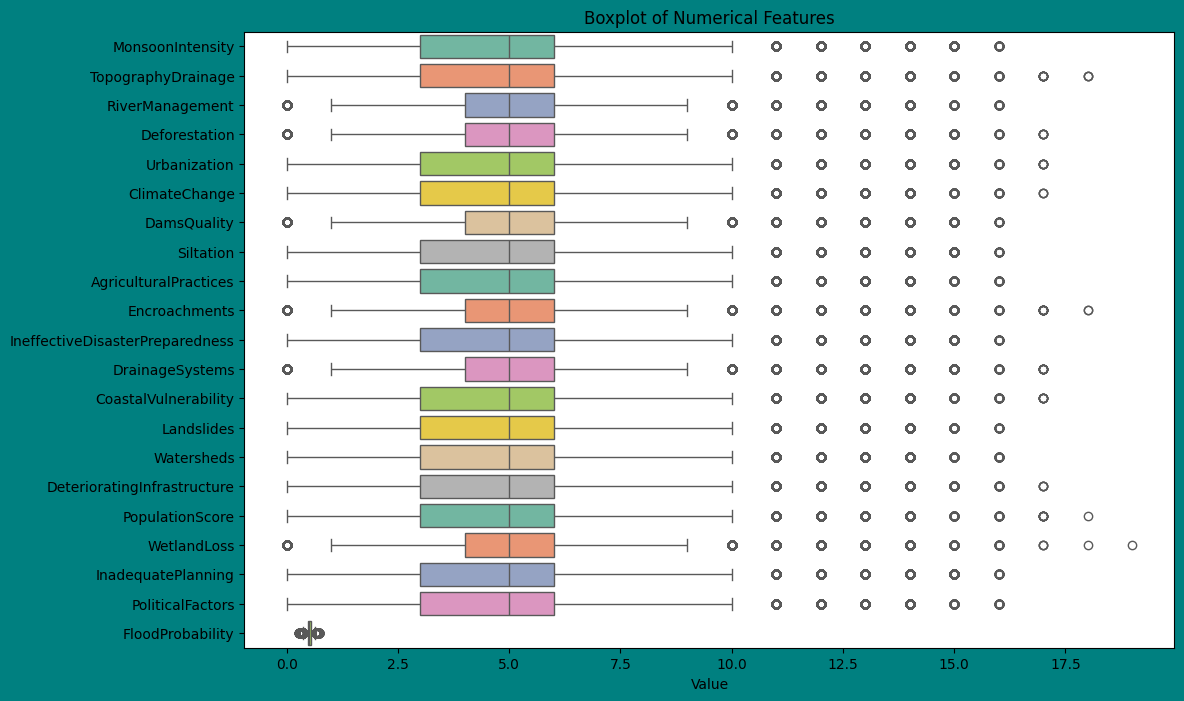

In [126]:
numeric_features = df_train.select_dtypes(include=['int64', 'float64']).columns.drop('id')
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_train[numeric_features], orient="h", palette="Set2")
plt.title('Boxplot of Numerical Features')
plt.xlabel('Value')
plt.gcf().set_facecolor('#008080')
plt.show()

In [127]:
# Function to calculate the number of outliers for each column
def count_outliers(df, columns):
    outlier_counts = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_counts[col] = outliers.shape[0]
    return outlier_counts

# List of columns to check for outliers (excluding the target variable)
columns = df_train.columns

# Count the outliers
outlier_counts = count_outliers(df_train, columns)

# Print the counts of outliers for each column
for col, count in outlier_counts.items():
    print(f'{col}: {count} outliers')

id: 0 outliers
MonsoonIntensity: 9244 outliers
TopographyDrainage: 9575 outliers
RiverManagement: 29617 outliers
Deforestation: 28235 outliers
Urbanization: 9184 outliers
ClimateChange: 8702 outliers
DamsQuality: 31097 outliers
Siltation: 9079 outliers
AgriculturalPractices: 9006 outliers
Encroachments: 31141 outliers
IneffectiveDisasterPreparedness: 8945 outliers
DrainageSystems: 30060 outliers
CoastalVulnerability: 10209 outliers
Landslides: 8865 outliers
Watersheds: 9245 outliers
DeterioratingInfrastructure: 8971 outliers
PopulationScore: 9290 outliers
WetlandLoss: 29499 outliers
InadequatePlanning: 9299 outliers
PoliticalFactors: 9707 outliers
FloodProbability: 5579 outliers


# Checking Linearity

*In order to assess whether or not there is a linear relationship between the independent and dependent variables, it is easiest to create a scatterplot of the dataset. The independent variable would be on the x-axis, and the dependent variable would be on the y-axis. There are a number of different Python functions that you can use to read in the data and to create a scatterplot*

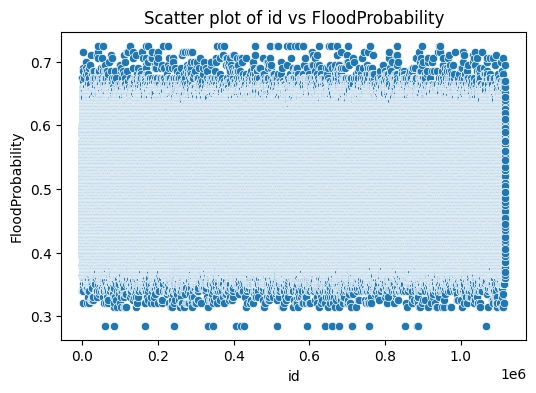

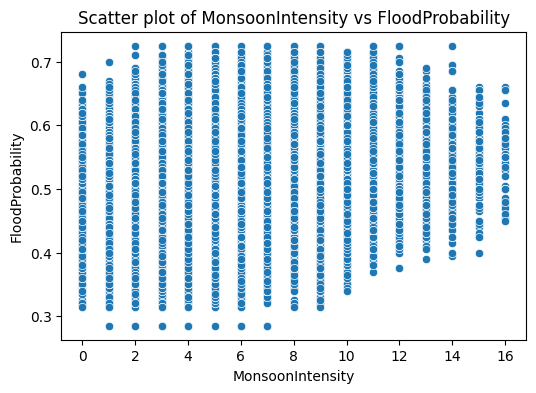

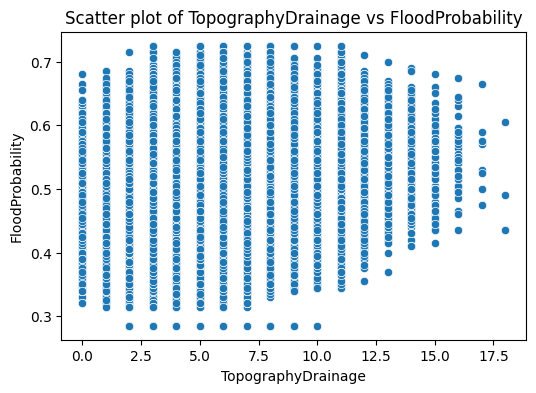

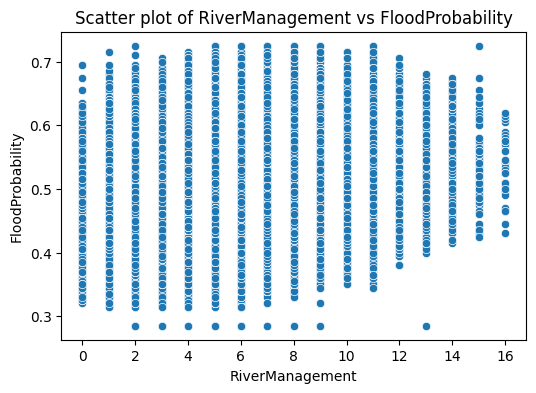

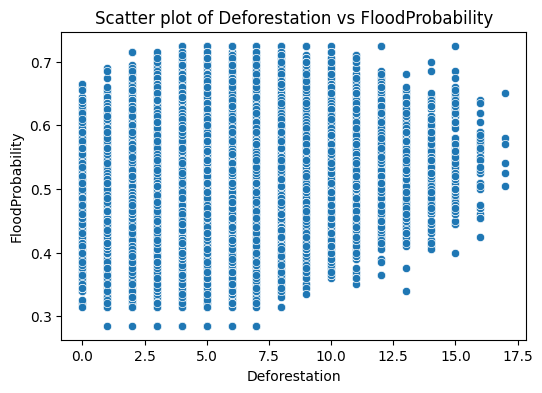

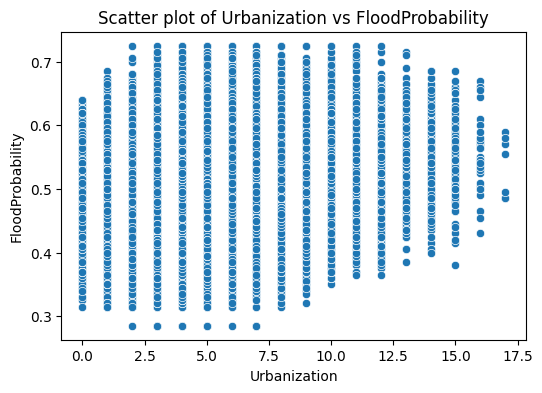

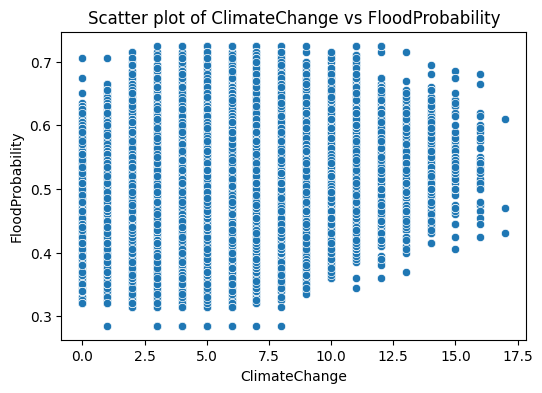

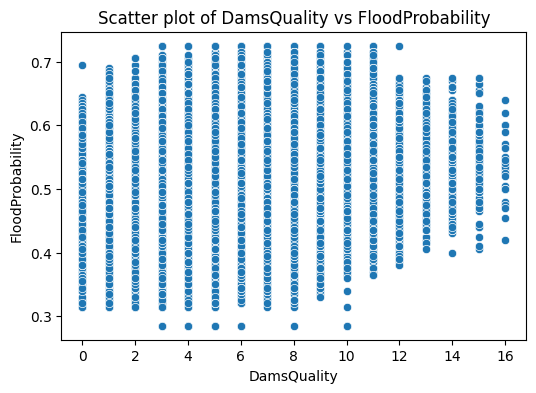

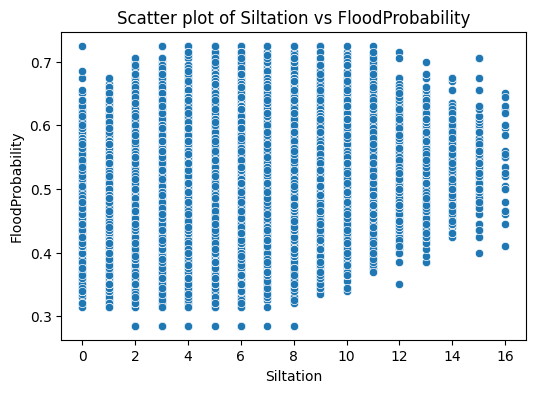

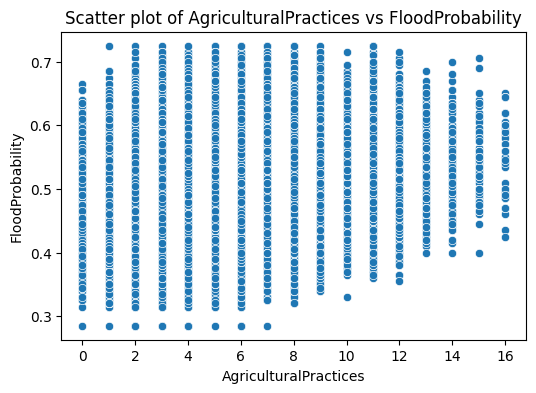

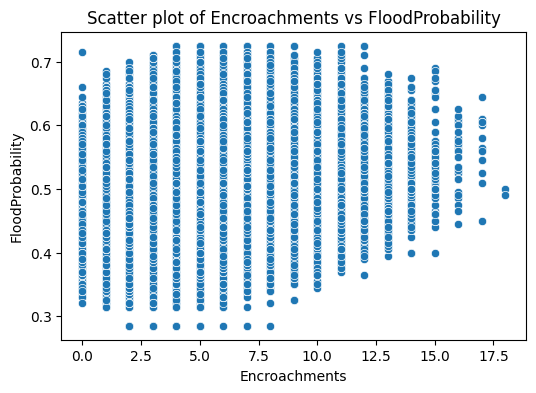

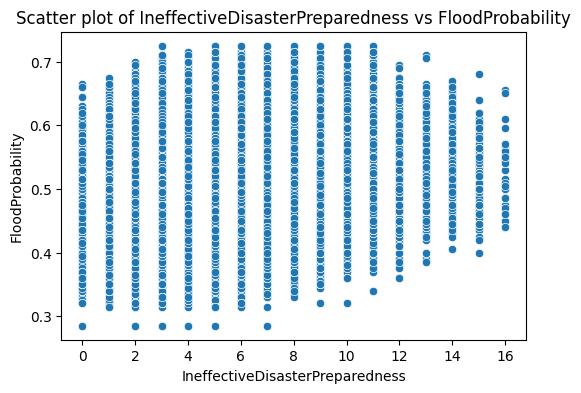

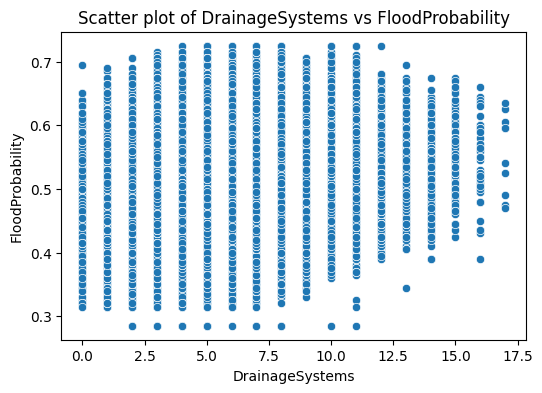

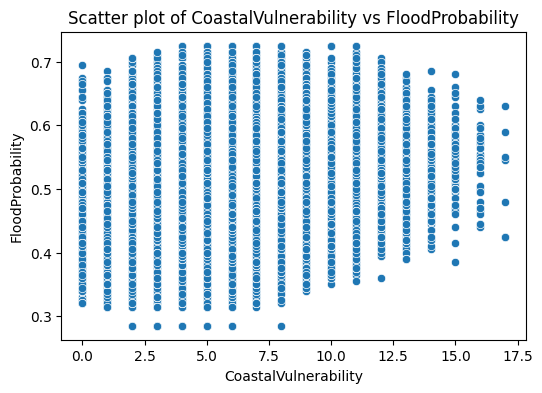

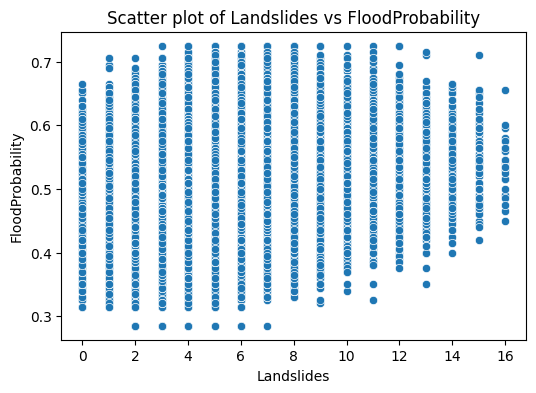

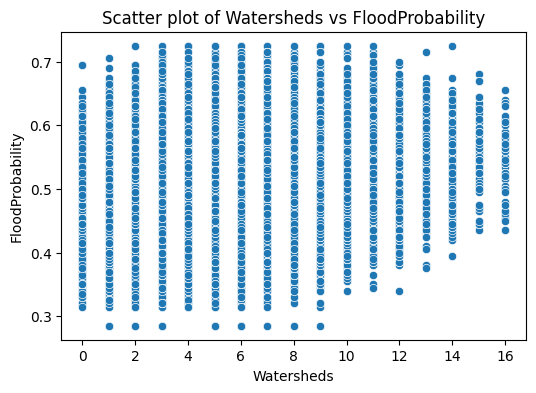

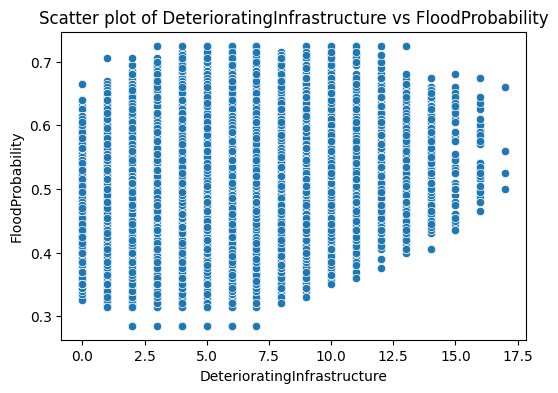

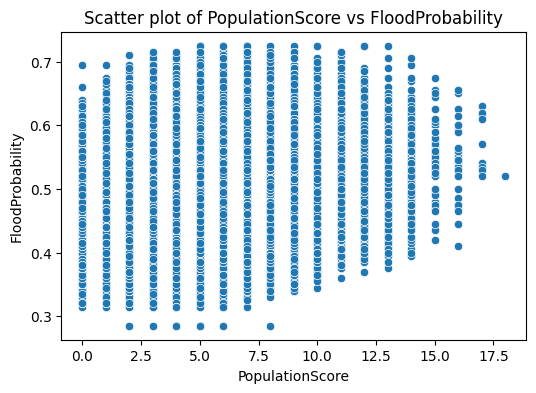

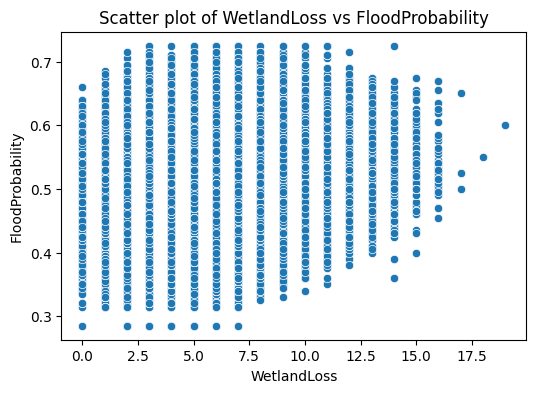

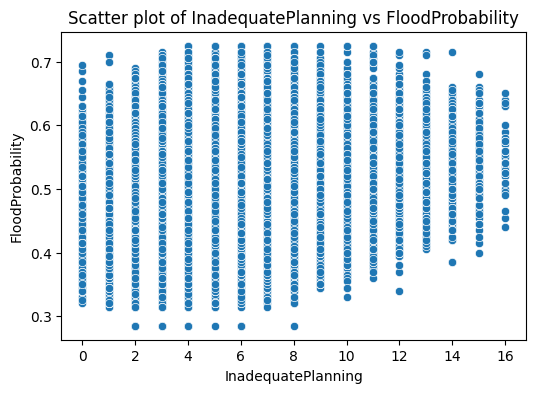

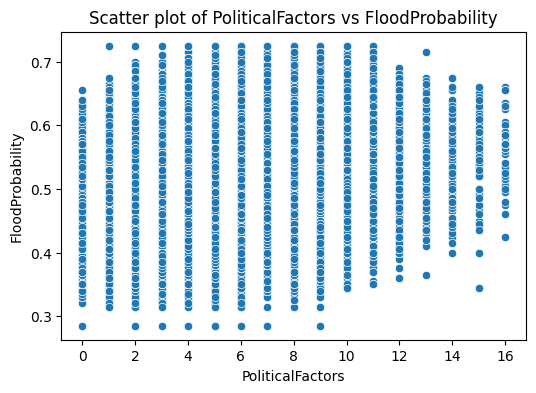

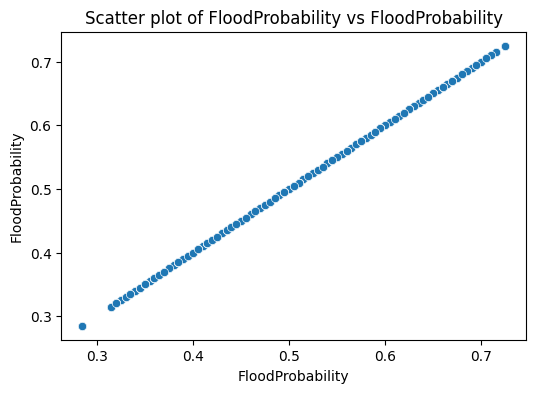

In [128]:
# Scatter plots for each feature vs. the target variable
for col in df_train.columns:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df_train[col], y=df_train['FloodProbability'])
    plt.title(f'Scatter plot of {col} vs FloodProbability')
    plt.xlabel(col)
    plt.ylabel('FloodProbability')
    plt.show()

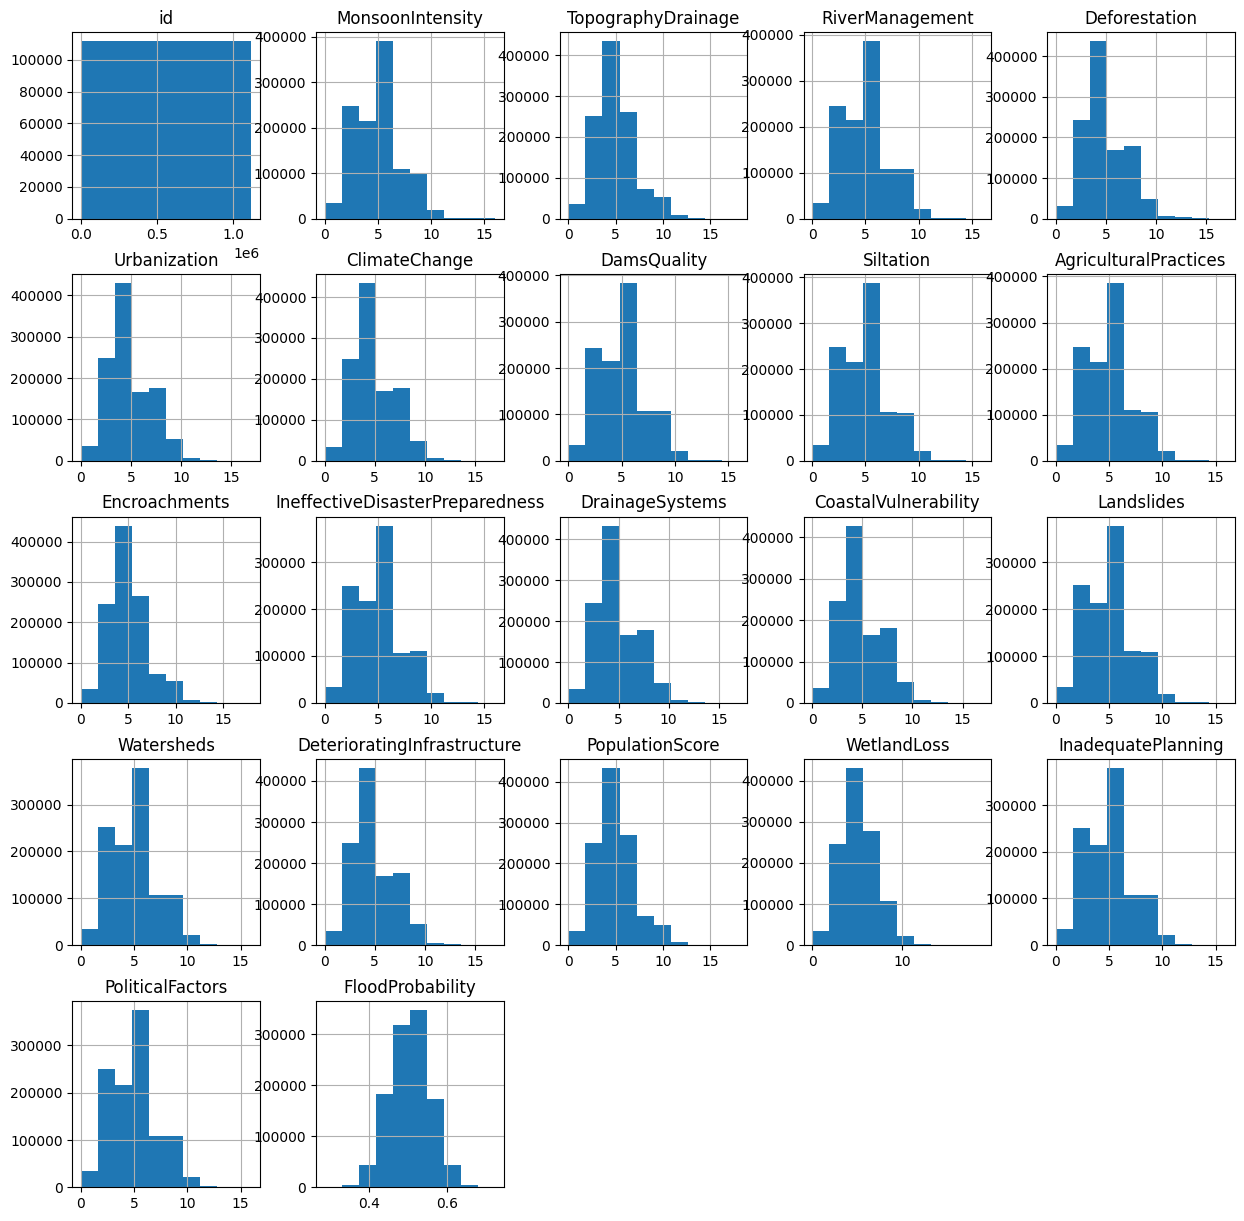

In [129]:
# Target Distrpution
df_train.hist(figsize=(15,15));

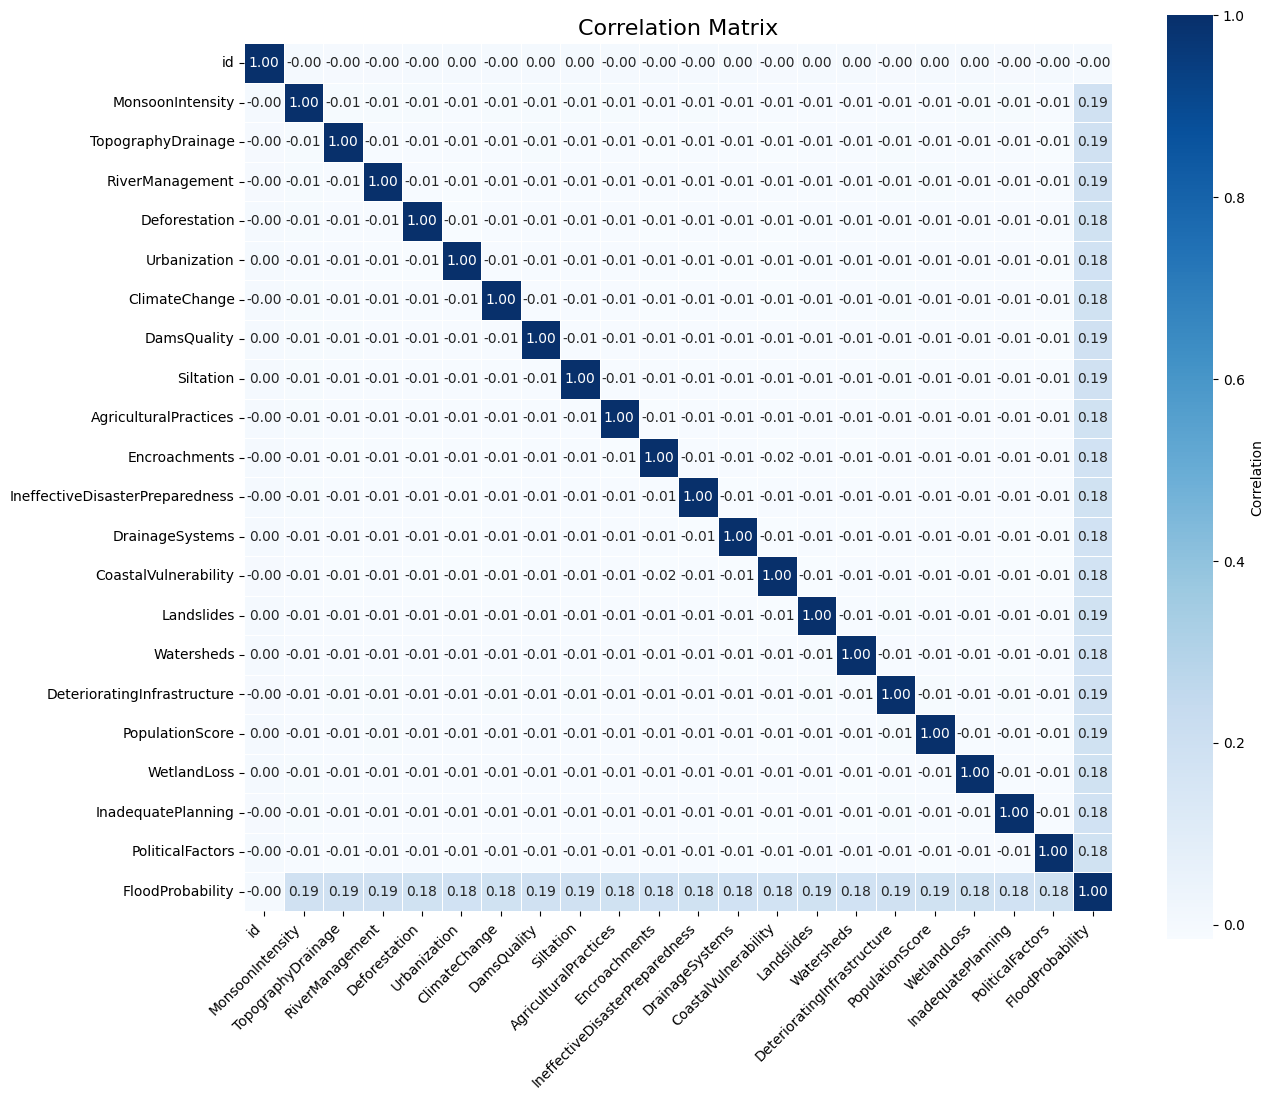

In [130]:
# Correlation
corr = df_train.corr()
# Plot the correlation matrix with a larger size and increased cell spacing
plt.figure(figsize=(14, 12))
sns.heatmap(corr, cmap="Blues", annot=True, fmt=".2f", linewidths=0.5, square=True, cbar_kws={'label': 'Correlation', 'orientation': 'vertical'})

plt.title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

# Checking Collinearity

**What is VIF?**

Variance Inflation Factor (VIF) is a measure used to detect the presence and severity of multicollinearity in regression analysis. Multicollinearity occurs when two or more predictor variables in a regression model are highly correlated, meaning that one predictor can be linearly predicted from the others with a substantial degree of accuracy.


1. VIF = 1: No correlation between the predictor and the other predictors.

2. 1 < VIF < 5: Moderate correlation but usually acceptable.

3. VIF > 5: Indicates potentially problematic multicollinearity.

4. VIF > 10: Indicates serious multicollinearity.

In [131]:
df_train_with_const = add_constant(df_train)


vif_data = pd.DataFrame()
vif_data["feature"] = df_train_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(df_train_with_const.values, i) for i in range(df_train_with_const.shape[1])]

In [132]:
vif_data

,feature,VIF
0,const,152.517829
1,id,1.000011
2,MonsoonIntensity,1.331574
3,TopographyDrainage,1.348860
4,RiverManagement,1.343868
5,Deforestation,1.338782
6,Urbanization,1.347294
7,ClimateChange,1.338716
8,DamsQuality,1.346030
9,Siltation,1.338225


In [133]:
df_test.isnull().sum()

,0
id,0
MonsoonIntensity,0
TopographyDrainage,0
RiverManagement,0
Deforestation,0
Urbanization,0
ClimateChange,0
DamsQuality,0
Siltation,0
AgriculturalPractices,0


# Modelling

**Step-by-Step Integration**

**1. Define Configuration and Setup**

**2. Define Feature Engineering Class**

**3. Define Model Scoring Function**

**4. Run the Model and Evaluate**

In [134]:
# Define the configuration
config = {
    'N_SPLITS': 5,
    'SEED': 42,
    'USE_ORIGINAL': False  # Set to True if using additional original data
}

TARGET = 'FloodProbability'

# Assuming df_train is your DataFrame and df_test is your test set
X = df_train.drop(columns=[TARGET])
y = df_train[TARGET]
test = df_test  # Assuming df_test is already defined

In [135]:
# Define Feature Engineering Class
class FE(BaseEstimator, TransformerMixin):
    def __init__(self, use_quantile=False, sort=False):
        self.use_quantile = use_quantile
        self.sort = sort

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        x_copy = X.copy()
        features = x_copy.columns.tolist()
        x_copy['mean_features'] = 0.1 * x_copy[features].mean(axis=1)
        x_copy['std_features'] = x_copy[features].std(axis=1)
        x_copy['max_features'] = x_copy[features].max(axis=1)
        x_copy['min_features'] = x_copy[features].min(axis=1)
        x_copy['median_features'] = 0.1 * x_copy[features].median(axis=1)
        x_copy['sum_features'] = x_copy[features].sum(axis=1)

        if self.sort:
            sorted_values = np.sort(x_copy[features].values, axis=1)
            sorted_features = [f'sort_{i}' for i in range(sorted_values.shape[1])]
            sorted_df = pd.DataFrame(sorted_values, columns=sorted_features, index=x_copy.index)
            x_copy = pd.concat([x_copy, sorted_df], axis=1)

        if self.use_quantile:
            x_copy['q1'] = x_copy[features].quantile(0.25, axis=1)
            x_copy['q3'] = x_copy[features].quantile(0.75, axis=1)

        return x_copy.drop(features, axis=1)


In [136]:
# Define Model Scoring Function
kf = KFold(n_splits=config['N_SPLITS'], random_state=config['SEED'], shuffle=True)

def score_model(estimator, label=''):
    val_predictions = np.zeros((len(X)))
    test_predictions = np.zeros((len(test)))
    val_scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        model = clone(estimator)

        X_train = X.iloc[train_idx].reset_index(drop=True)
        y_train = y.iloc[train_idx].reset_index(drop=True)
        X_val = X.iloc[val_idx].reset_index(drop=True)
        y_val = y.iloc[val_idx].reset_index(drop=True)

        model.fit(X_train, y_train)
        val_preds = model.predict(X_val)
        val_predictions[val_idx] += val_preds
        test_predictions += model.predict(test) / kf.get_n_splits()

        val_score = r2_score(y_val, val_preds)
        val_scores.append(val_score)

        print(f'Fold {fold+1}: {val_score:.5f}')

    print(f'Val Score: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | {label}')

    return val_scores, val_predictions, test_predictions


# Xgboost

Fold 1: 0.85113
Fold 2: 0.85156
Fold 3: 0.85096
Fold 4: 0.85127
Fold 5: 0.85134
Val Score: 0.85125 ± 0.00020 | XGB


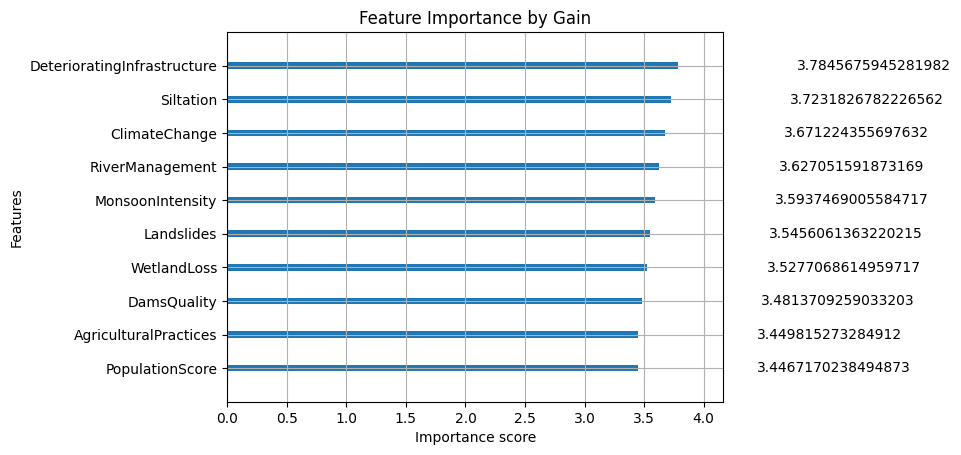

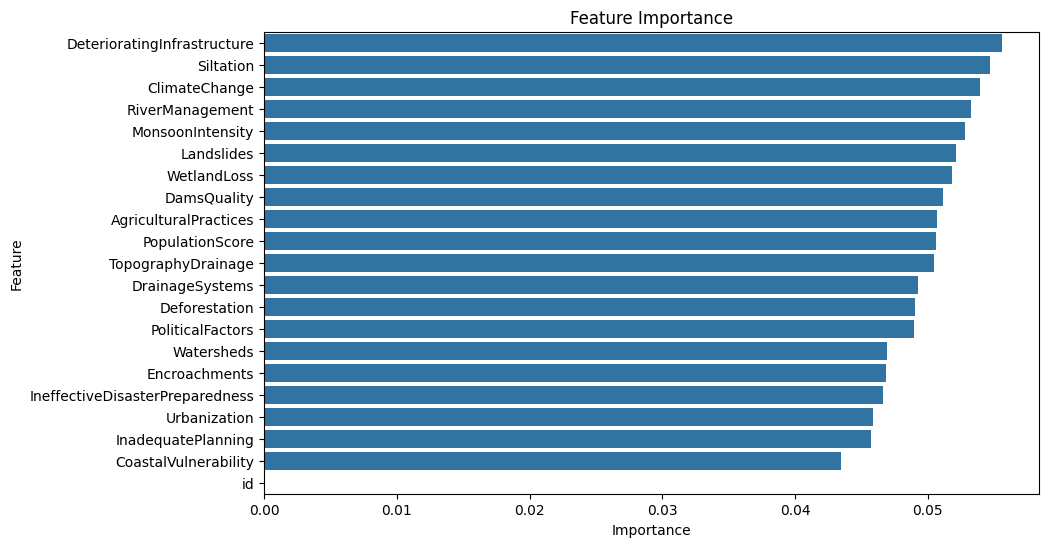

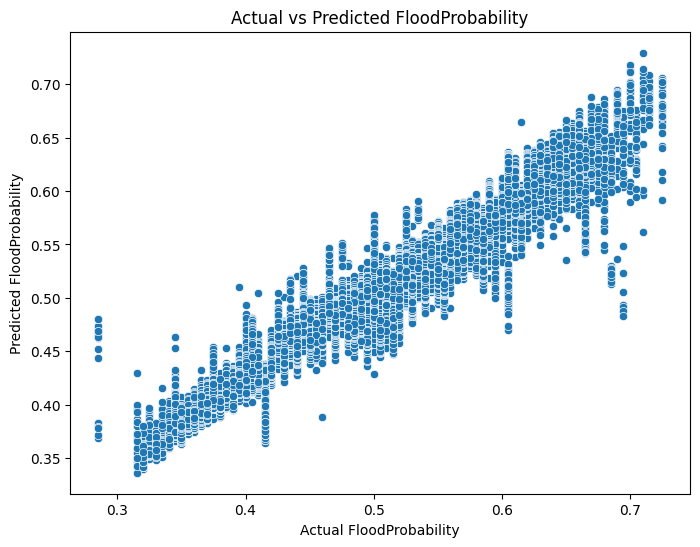

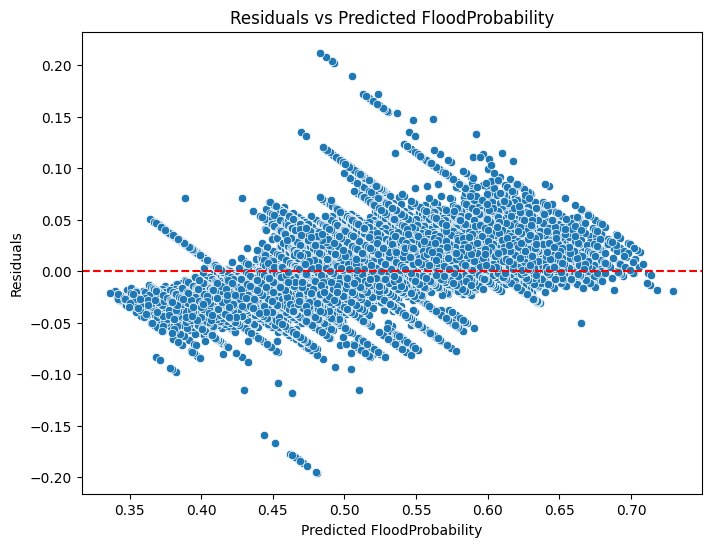

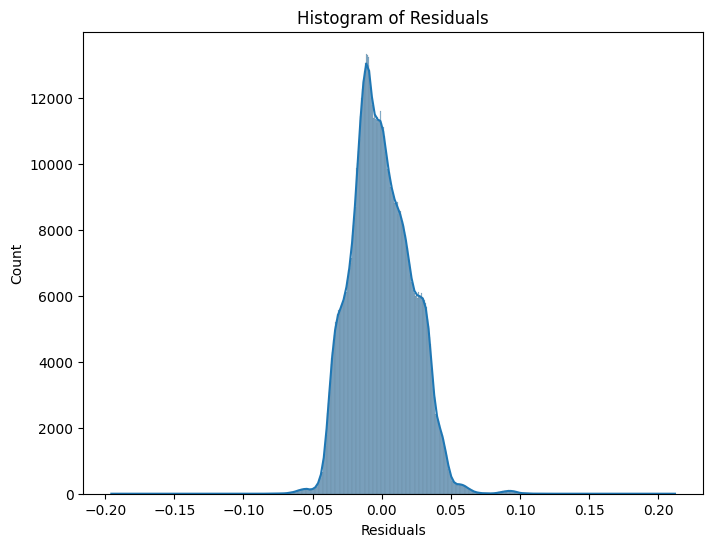

In [137]:
# Run the Model and Evaluate
scores, oof, test_preds = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

# Train and evaluate the XGBoost model
scores['XGB'], oof['XGB'], test_preds['XGB'] = score_model(
    make_pipeline(
        FE(use_quantile=True, sort=True),
        xgb.XGBRegressor(
            n_estimators=600,
            max_depth=4,
            learning_rate=0.04,
            objective='reg:squarederror',
            random_state=config['SEED']
        )
    ),
    'XGB'
)

# Visualize feature importance
model = xgb.XGBRegressor(
    n_estimators=600,
    max_depth=4,
    learning_rate=0.04,
    objective='reg:squarederror',
    random_state=config['SEED']
)
model.fit(X, y)
xgb.plot_importance(model, max_num_features=10, importance_type='gain')
plt.title('Feature Importance by Gain')
plt.show()

# Custom feature importance plot
importance = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

# Scatter plot of predicted vs actual values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y, y=model.predict(X))
plt.xlabel('Actual FloodProbability')
plt.ylabel('Predicted FloodProbability')
plt.title('Actual vs Predicted FloodProbability')
plt.show()

# Residual plot
residuals = y - model.predict(X)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=model.predict(X), y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted FloodProbability')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted FloodProbability')
plt.show()

# Histogram of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Histogram of Residuals')
plt.show()

# Catboost

Fold 1: 0.85476
Fold 2: 0.85518
Fold 3: 0.85479
Fold 4: 0.85515
Fold 5: 0.85504
Val Score: 0.85499 ± 0.00018 | CatBoost


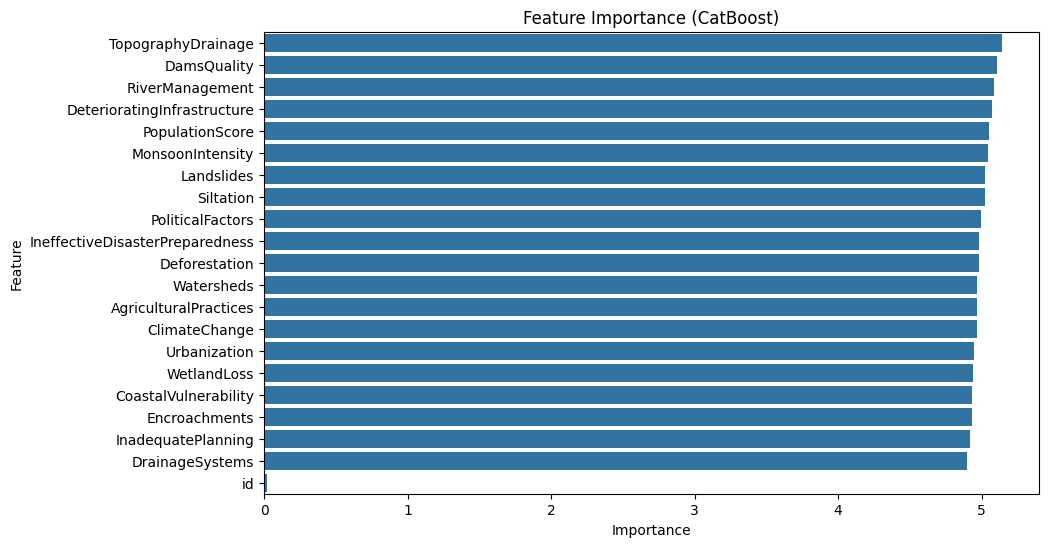

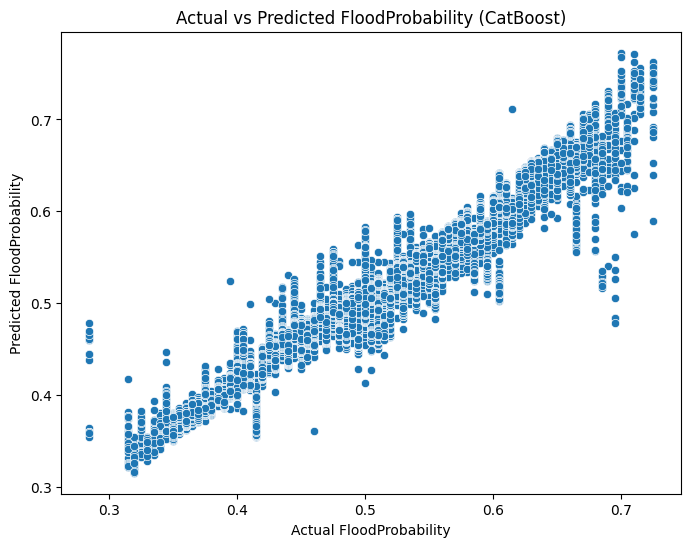

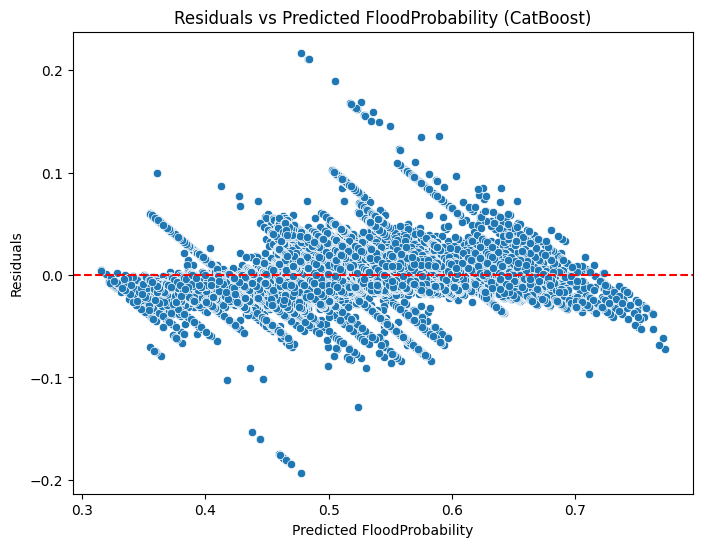

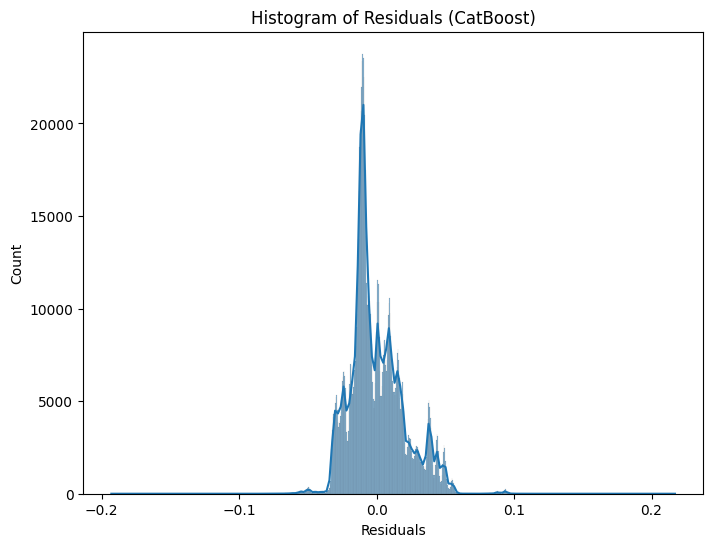

In [138]:
# Train and evaluate the CatBoost model
scores['CatBoost'], oof['CatBoost'], test_preds['CatBoost'] = score_model(
    make_pipeline(
        FE(use_quantile=True, sort=True),
        CatBoostRegressor(
            iterations=2000,
            verbose=False,
            random_state=config['SEED']
        )
    ),
    'CatBoost'
)

# Visualize feature importance for CatBoost
model = CatBoostRegressor(
    iterations=2000,
    verbose=False,
    random_state=config['SEED']
)
model.fit(X, y)

# CatBoost doesn't have built-in feature importance visualization like XGBoost,
# but you can access feature importance directly from the model object
# Custom feature importance plot for CatBoost
importance = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance (CatBoost)')
plt.show()

# Scatter plot of predicted vs actual values for CatBoost
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y, y=model.predict(X))
plt.xlabel('Actual FloodProbability')
plt.ylabel('Predicted FloodProbability')
plt.title('Actual vs Predicted FloodProbability (CatBoost)')
plt.show()

# Residual plot for CatBoost
residuals = y - model.predict(X)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=model.predict(X), y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted FloodProbability')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted FloodProbability (CatBoost)')
plt.show()

# Histogram of residuals for CatBoost
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Histogram of Residuals (CatBoost)')
plt.show()

# Linear Regression

In [140]:
# 1️⃣ feature names from training
train_columns = X.columns

# 2️⃣ your place data (dictionary)
my_place = {
    "MonsoonIntensity": 12,
    "TopographyDrainage": 8,
    "RiverManagement": 7,
    "Deforestation": 6,
    "Urbanization": 9,
    "ClimateChange": 10,
    "DamsQuality": 7,
    "Siltation": 8,
    "AgriculturalPractices": 6,
    "Encroachments": 7,
    "IneffectiveDisasterPreparedness": 8,
    "DrainageSystems": 9,
    "CoastalVulnerability": 4,
    "Landslides": 5,
    "Watersheds": 7,
    "DeterioratingInfrastructure": 8,
    "PopulationScore": 11,
    "WetlandLoss": 6,
    "InadequatePlanning": 7,
    "PoliticalFactors": 6
}

# 3️⃣ convert to DataFrame
my_place_df = pd.DataFrame([my_place])

# 4️⃣ ALIGN columns with training data (IMPORTANT)
my_place_df = my_place_df.reindex(columns=train_columns, fill_value=0)

# 5️⃣ predict
prob = final_model.predict(my_place_df)[0]
print("Flood Probability:", round(prob, 3))

# 6️⃣ risk level
if prob < 0.3:
    risk = "🟢 SAFE"
elif prob < 0.6:
    risk = "🟡 WARNING"
else:
    risk = "🔴 HIGH FLOOD RISK"

print("Flood Risk Level:", risk)


Flood Probability: 0.758
Flood Risk Level: 🔴 HIGH FLOOD RISK
